In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('results_new.csv')
df = df.sort_values(by=['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos', 'topics'])


# Display the first few rows of the DataFrame
df.head()


,simulation_number,publisher_number,subscriber_number,message_size,retain,qos,topics,ram_usage,database_size
382,0,1,1,1024,False,0,1,982670,1331.2
379,0,1,1,1024,False,0,4,993795,3481.6
371,0,1,1,1024,False,0,8,1011637,9318.4
363,0,1,1,1024,False,1,1,1009407,1228.8
365,0,1,1,1024,False,1,4,1014277,14131.2


In [3]:
# Drop simulation_number column from df
df = df.drop('simulation_number', axis=1)

In [4]:
# Find the NaN values in the DataFrame
# There could be NaN values due to some errors during the simulation
print(df.isna().sum())
# Drop the colums that includes nan in df
df = df.dropna()

publisher_number     0
subscriber_number    0
message_size         0
retain               0
qos                  0
topics               0
ram_usage            0
database_size        4
dtype: int64


In [5]:
print(df.dtypes)
# Need to convert ram_usage to numeric
df['ram_usage'] = pd.to_numeric(df['ram_usage'], errors='coerce')


publisher_number       int64
subscriber_number      int64
message_size           int64
retain                  bool
qos                    int64
topics                 int64
ram_usage             object
database_size        float64
dtype: object


In [6]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Display correlation with database_size and ram_usage
print(correlation_matrix[['database_size', 'ram_usage']])

                   database_size  ram_usage
publisher_number        0.483504   0.552656
subscriber_number      -0.133519  -0.150714
message_size            0.298213   0.221700
retain                  0.012010   0.024590
qos                     0.091119   0.052873
topics                  0.240900   0.225185
ram_usage               0.816690   1.000000
database_size           1.000000   0.816690


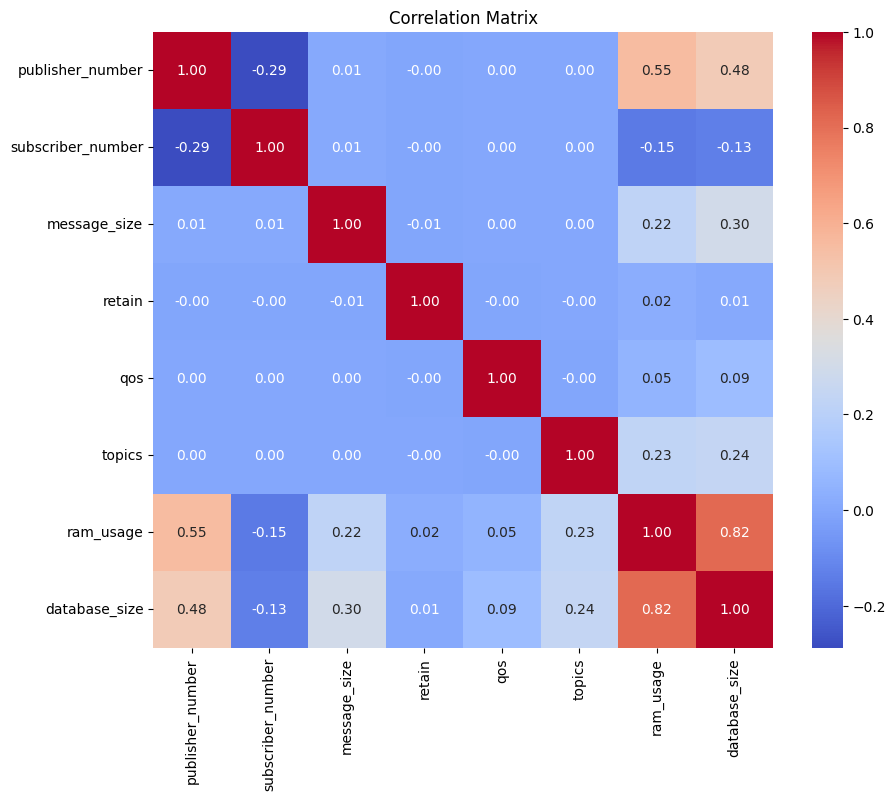

In [7]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


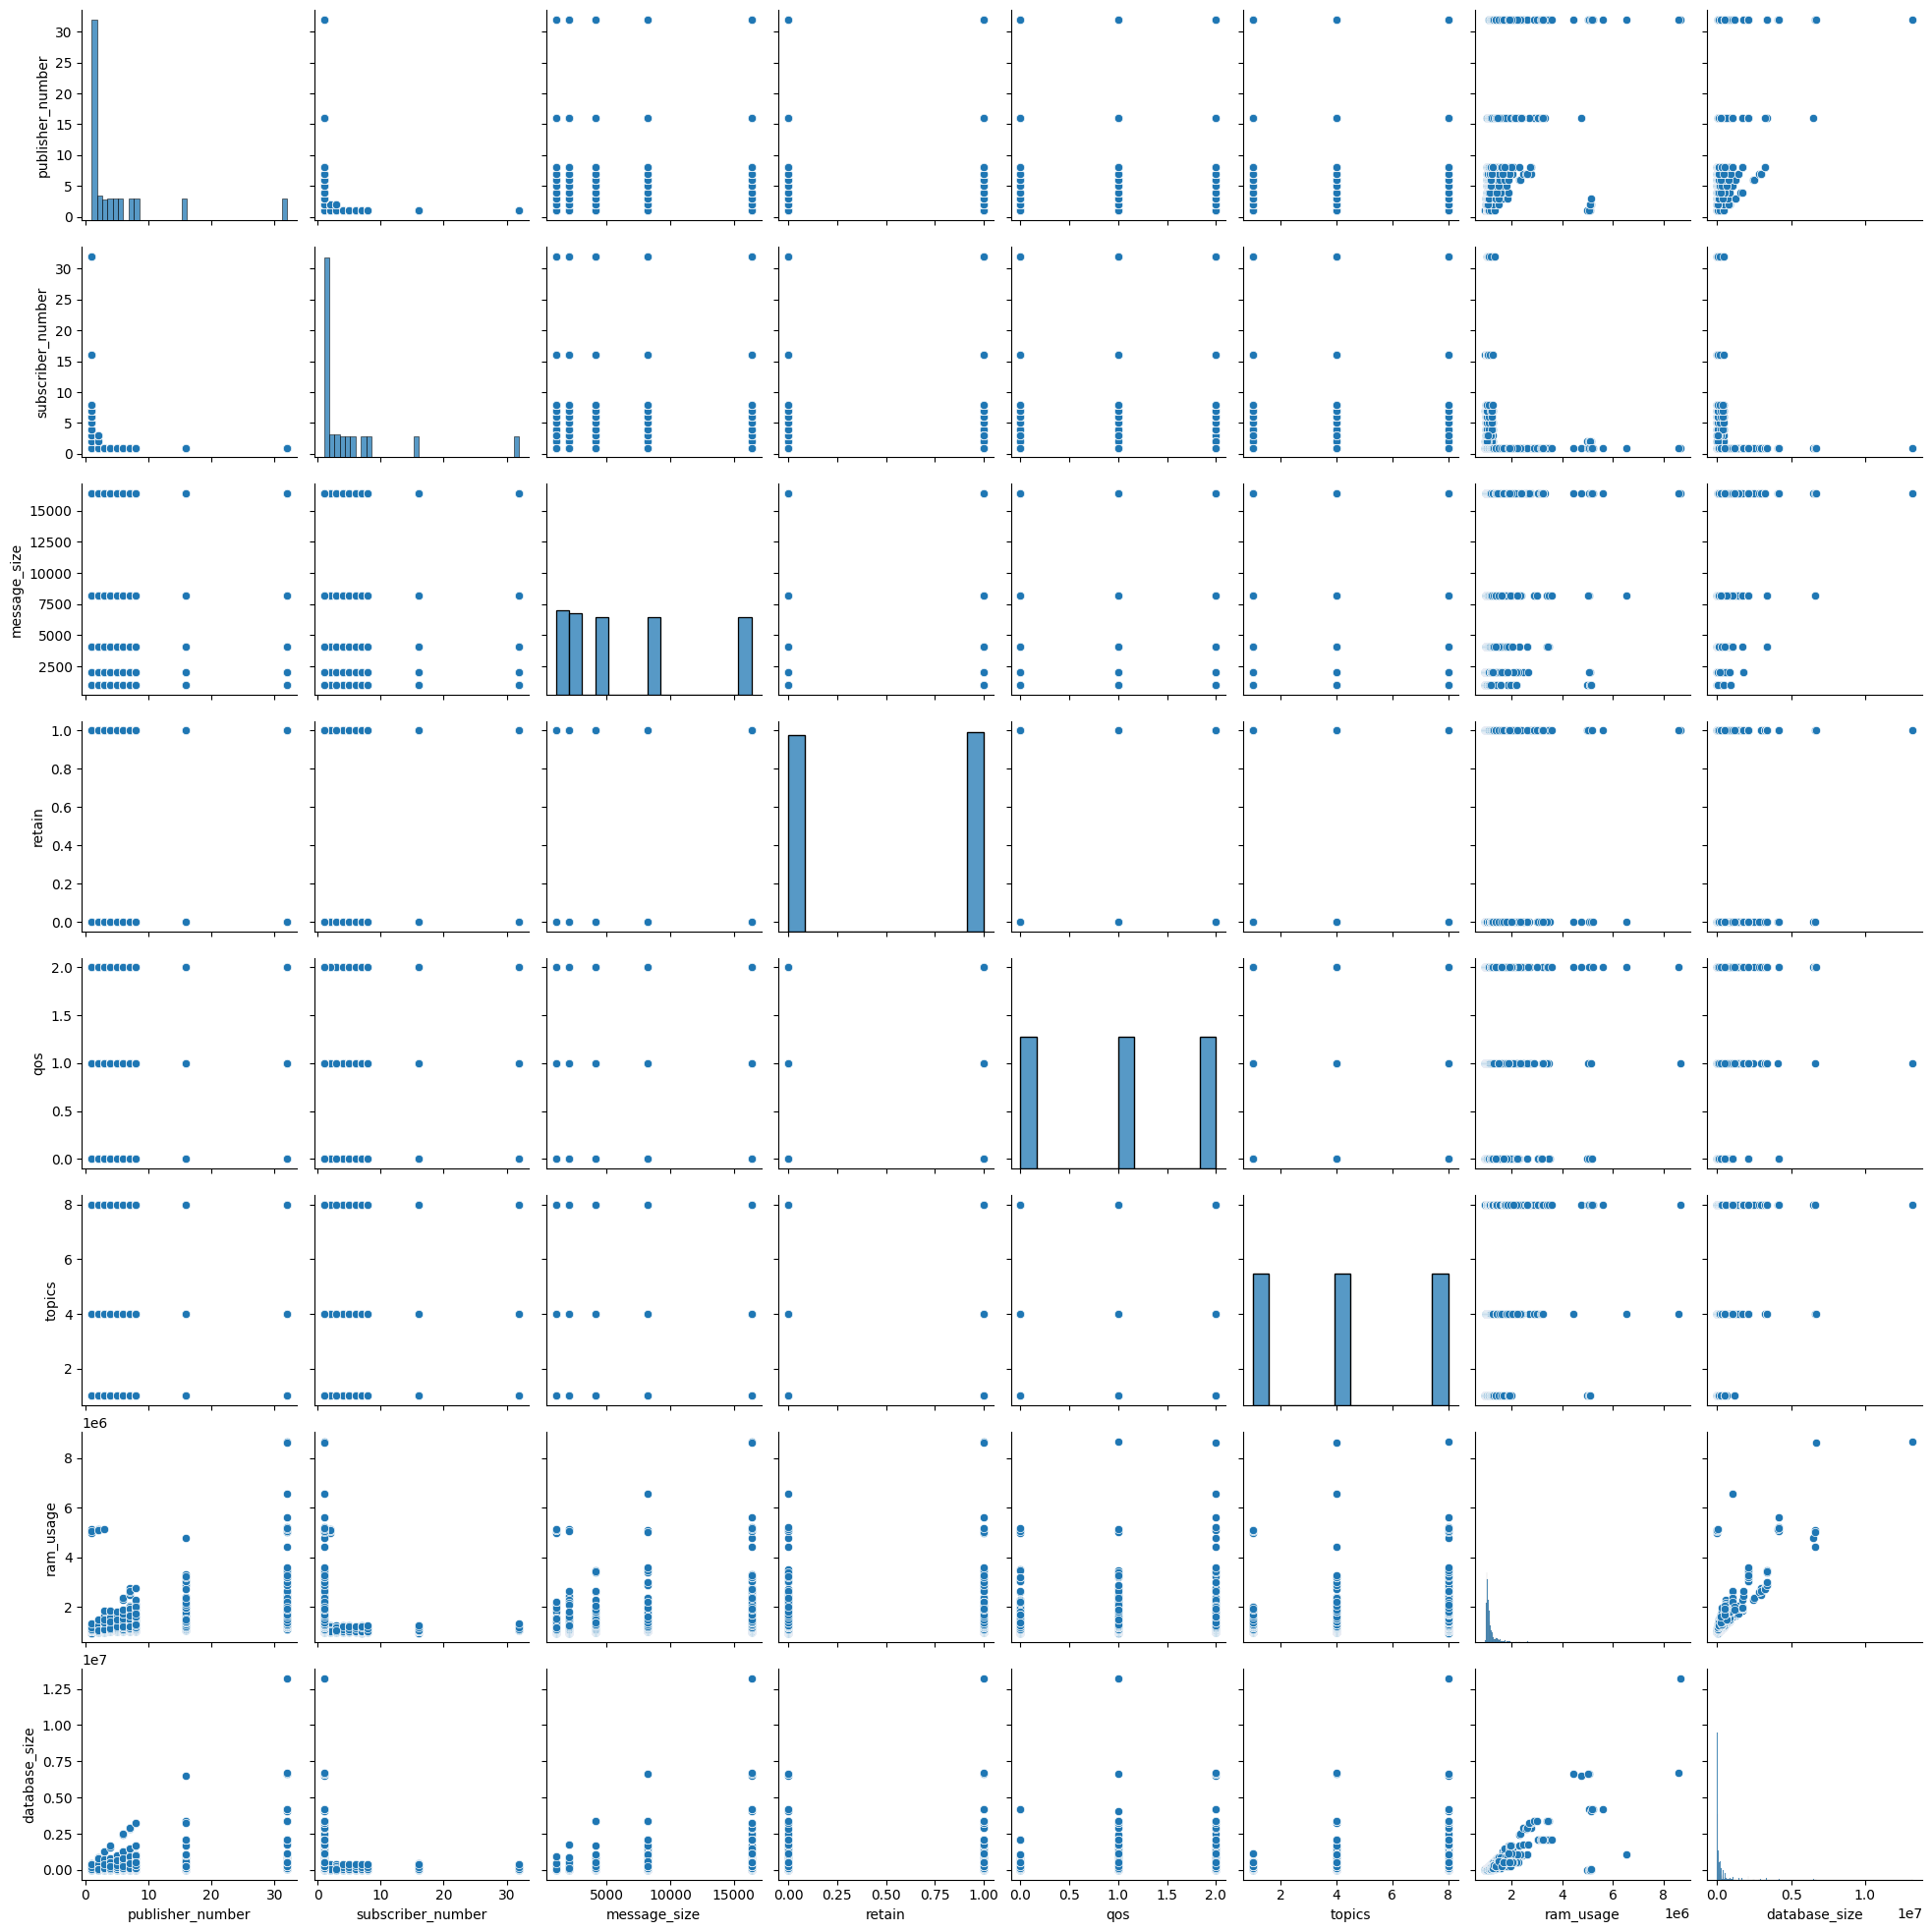

In [8]:
df['retain'] = df['retain'].astype(int)

# Create pairplot
sns.pairplot(df)
plt.show()

   retain  qos  database_size     ram_usage
0       0    0  138646.260870  1.186178e+06
1       0    1  246868.591304  1.237395e+06
2       0    2  298753.484058  1.282120e+06
3       1    0  137188.205714  1.227717e+06
4       1    1  319091.154448  1.280508e+06
5       1    2  276231.366906  1.284149e+06


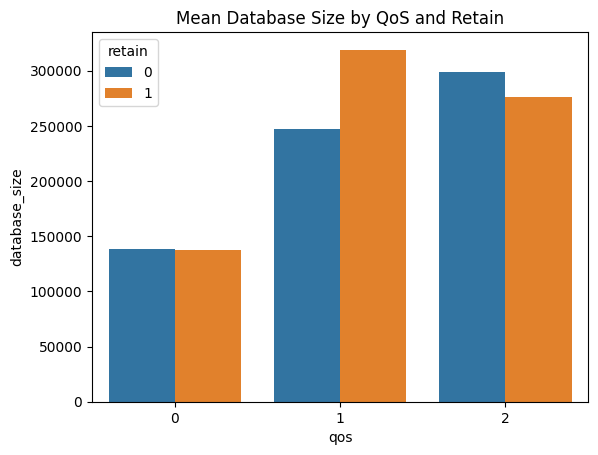

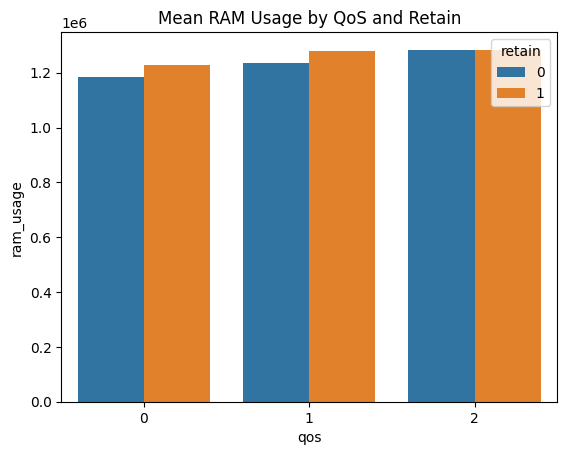

In [9]:
# Group by 'retain' and 'qos', and calculate the mean for 'database_size' and 'ram_usage'
group_means = df.groupby(['retain', 'qos']).agg({'database_size': 'mean', 'ram_usage': 'mean'}).reset_index()

# Display the grouped means
print(group_means)

# Plotting Mean Database Size by QoS and Retain
sns.barplot(data=group_means, x='qos', y='database_size', hue='retain')
plt.title('Mean Database Size by QoS and Retain')
plt.show()

# Plotting Mean RAM Usage by QoS and Retain
sns.barplot(data=group_means, x='qos', y='ram_usage', hue='retain')
plt.title('Mean RAM Usage by QoS and Retain')
plt.show()

In [10]:
# Define the feature variables (X) and target variables (y)
X = df[['publisher_number', 'subscriber_number', 'message_size', 'retain', 'qos', 'topics']]
y_db = df['database_size']
y_ram = df['ram_usage']
# Convert categorical variables to numeric
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train_db, y_test_db = train_test_split(X, y_db, test_size=0.3, random_state=42)
X_train, X_test, y_train_ram, y_test_ram = train_test_split(X, y_ram, test_size=0.3, random_state=42)

# Train the model for database_size
model_db = LinearRegression()
model_db.fit(X_train, y_train_db)

# Make predictions for database_size
y_pred_db = model_db.predict(X_test)

# Train the model for ram_usage
model_ram = LinearRegression()
model_ram.fit(X_train, y_train_ram)

# Make predictions for ram_usage
y_pred_ram = model_ram.predict(X_test)

# Evaluate the models
print(f'Database Size - R^2: {r2_score(y_test_db, y_pred_db)}, RMSE: {mean_squared_error(y_test_db, y_pred_db, squared=False)}')
print(f'RAM Usage - R^2: {r2_score(y_test_ram, y_pred_ram)}, RMSE: {mean_squared_error(y_test_ram, y_pred_ram, squared=False)}')


Database Size - R^2: 0.3653232037352113, RMSE: 362392.23636709
RAM Usage - R^2: 0.2800885603768306, RMSE: 408185.0777269159


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R^2 Score for Database Size: 0.72
MSE for Database Size: 58484586388.50
R^2 Score for RAM Usage: 0.53
MSE for RAM Usage: 107653376456.77


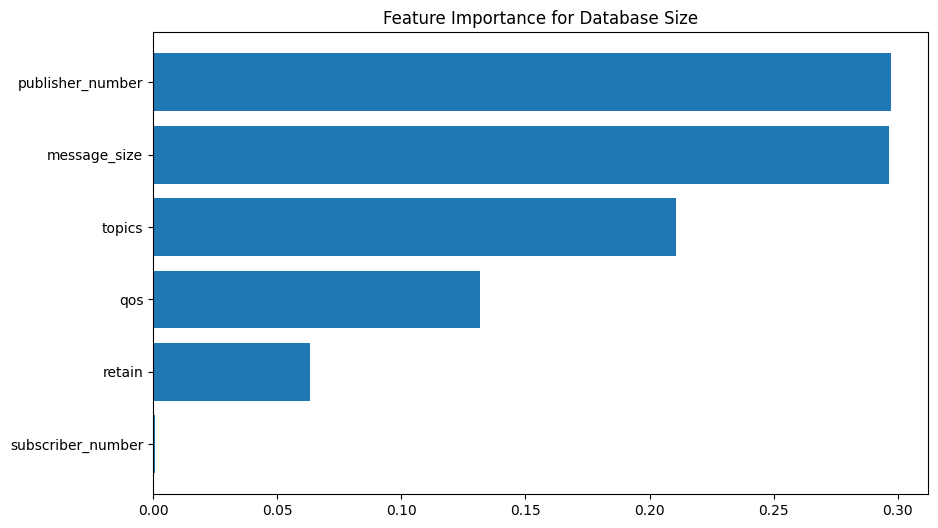

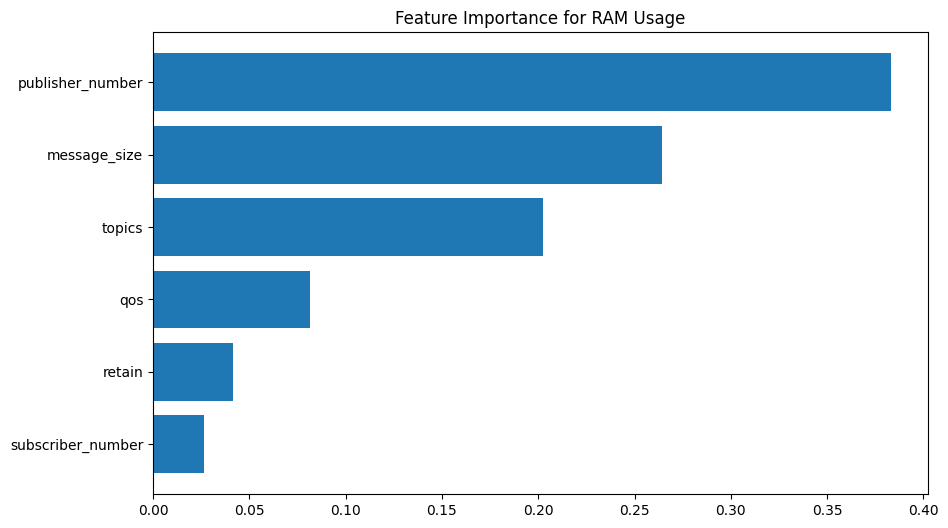

In [11]:
# Train a Random Forest model for database_size
rf_db = RandomForestRegressor(random_state=42)
rf_db.fit(X_train, y_train_db)
y_pred_db = rf_db.predict(X_test)

# Train a Random Forest model for ram_usage
rf_ram = RandomForestRegressor(random_state=42)
rf_ram.fit(X_train, y_train_ram)
y_pred_ram = rf_ram.predict(X_test)

# Calculate metrics for database_size
r2_db = r2_score(y_test_db, y_pred_db)
mse_db = mean_squared_error(y_test_db, y_pred_db)
print(f"R^2 Score for Database Size: {r2_db:.2f}")
print(f"MSE for Database Size: {mse_db:.2f}")

# Calculate metrics for ram_usage
r2_ram = r2_score(y_test_ram, y_pred_ram)
mse_ram = mean_squared_error(y_test_ram, y_pred_ram)
print(f"R^2 Score for RAM Usage: {r2_ram:.2f}")
print(f"MSE for RAM Usage: {mse_ram:.2f}")

# Feature importance for database_size
importances_db = rf_db.feature_importances_
feature_names = X.columns
sorted_indices_db = importances_db.argsort()

plt.figure(figsize=(10, 6))
plt.title('Feature Importance for Database Size')
plt.barh(range(len(sorted_indices_db)), importances_db[sorted_indices_db], align='center')
plt.yticks(range(len(sorted_indices_db)), feature_names[sorted_indices_db])
plt.show()

# Feature importance for ram_usage
importances_ram = rf_ram.feature_importances_
sorted_indices_ram = importances_ram.argsort()

plt.figure(figsize=(10, 6))
plt.title('Feature Importance for RAM Usage')
plt.barh(range(len(sorted_indices_ram)), importances_ram[sorted_indices_ram], align='center')
plt.yticks(range(len(sorted_indices_ram)), feature_names[sorted_indices_ram])
plt.show()


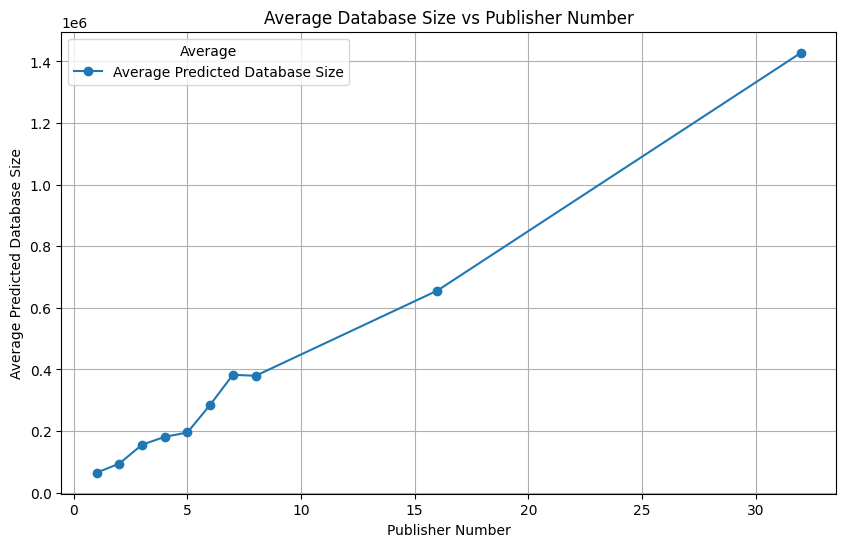

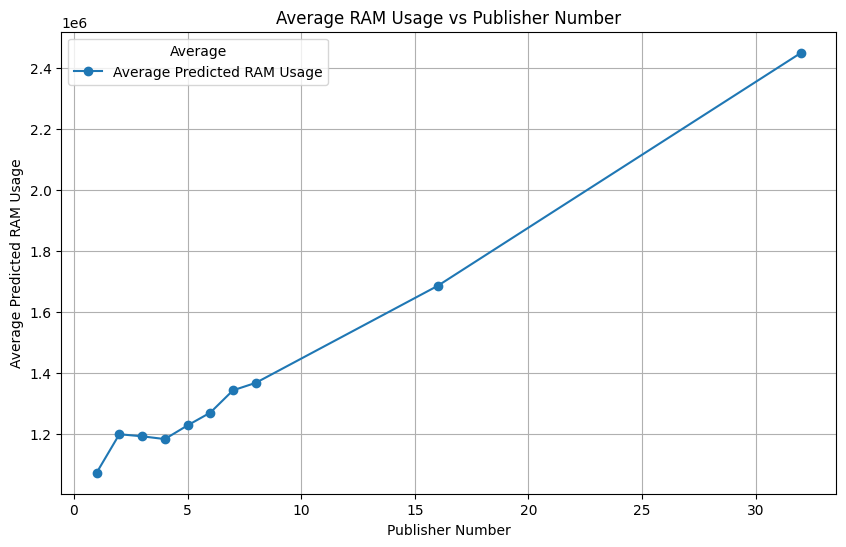

In [12]:
# Group by publisher_number and calculate the mean predicted_database_size
mean_df_publisher = df.groupby('publisher_number')['database_size'].mean().reset_index()

# Plot the averaged database size vs publisher number
plt.figure(figsize=(10, 6))
plt.plot(mean_df_publisher['publisher_number'], mean_df_publisher['database_size'], 'o-', label="Average Predicted Database Size")
plt.title("Average Database Size vs Publisher Number")
plt.xlabel('Publisher Number')
plt.ylabel('Average Predicted Database Size')
plt.grid(True)
plt.legend(title='Average')
plt.show()

# Group by publisher_number and calculate the mean predicted_ram_usage
mean_df_ram_publisher = df.groupby('publisher_number')['ram_usage'].mean().reset_index()

# Plot the averaged RAM usage vs publisher number
plt.figure(figsize=(10, 6))
plt.plot(mean_df_ram_publisher['publisher_number'], mean_df_ram_publisher['ram_usage'], 'o-', label="Average Predicted RAM Usage")
plt.title("Average RAM Usage vs Publisher Number")
plt.xlabel('Publisher Number')
plt.ylabel('Average Predicted RAM Usage')
plt.grid(True)
plt.legend(title='Average')
plt.show()


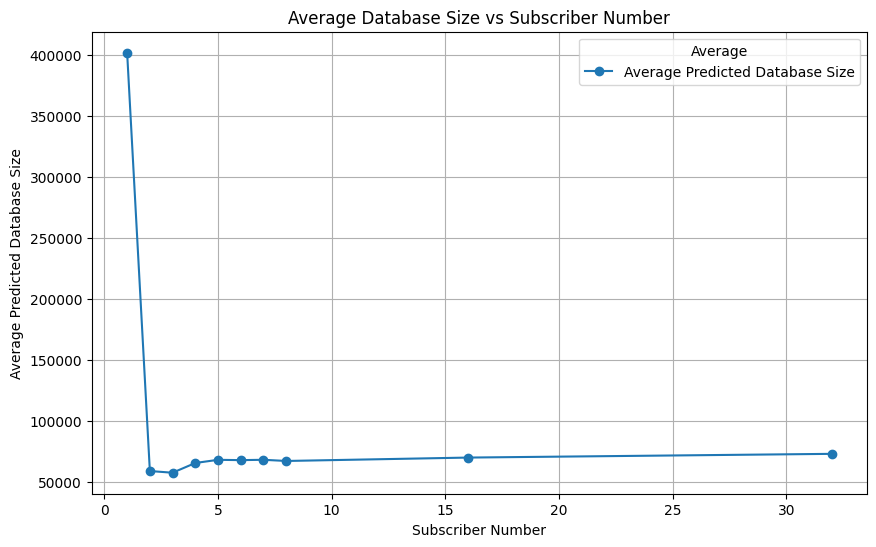

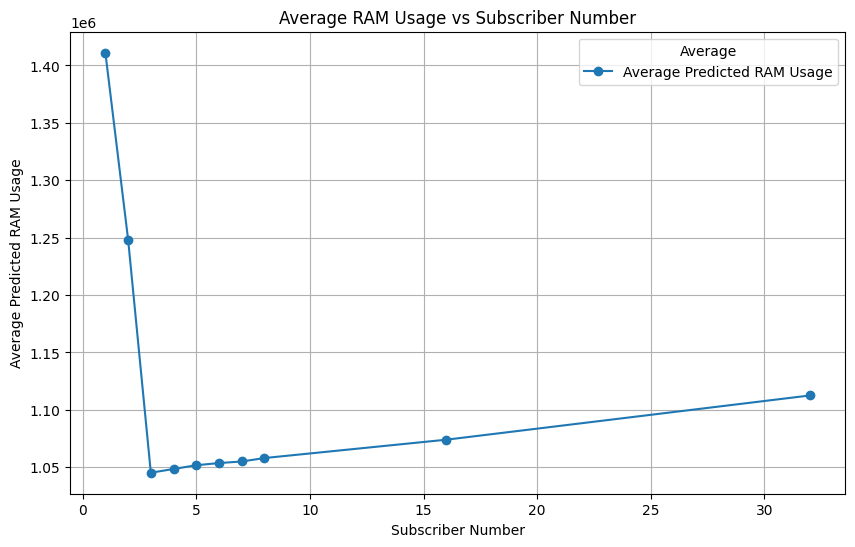

In [13]:
# Group by subscriber_number and calculate the mean predicted_database_size
mean_df_subscriber = df.groupby('subscriber_number')['database_size'].mean().reset_index()

# Plot the averaged database size vs subscriber number
plt.figure(figsize=(10, 6))
plt.plot(mean_df_subscriber['subscriber_number'], mean_df_subscriber['database_size'], 'o-', label="Average Predicted Database Size")
plt.title("Average Database Size vs Subscriber Number")
plt.xlabel('Subscriber Number')
plt.ylabel('Average Predicted Database Size')
plt.grid(True)
plt.legend(title='Average')
plt.show()

# Group by subscriber_number and calculate the mean predicted_ram_usage
mean_df_ram_subscriber = df.groupby('subscriber_number')['ram_usage'].mean().reset_index()

# Plot the averaged RAM usage vs subscriber number
plt.figure(figsize=(10, 6))
plt.plot(mean_df_ram_subscriber['subscriber_number'], mean_df_ram_subscriber['ram_usage'], 'o-', label="Average Predicted RAM Usage")
plt.title("Average RAM Usage vs Subscriber Number")
plt.xlabel('Subscriber Number')
plt.ylabel('Average Predicted RAM Usage')
plt.grid(True)
plt.legend(title='Average')
plt.show()


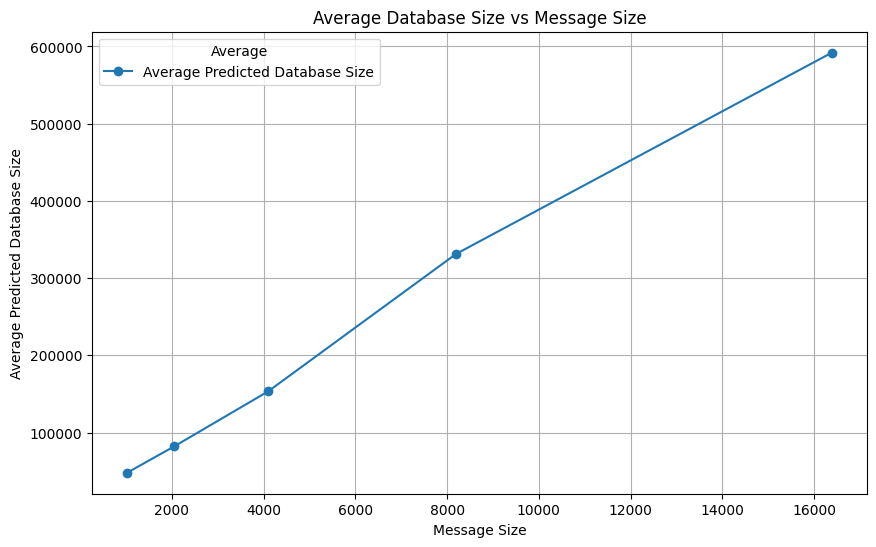

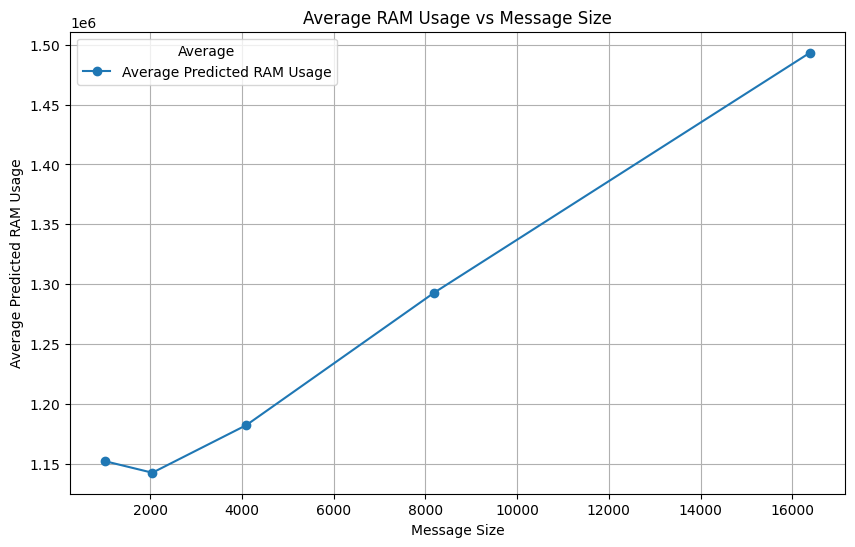

In [14]:
# Group by message_size and calculate the mean predicted_database_size
mean_df_message_size = df.groupby('message_size')['database_size'].mean().reset_index()

# Plot the averaged database size vs message size
plt.figure(figsize=(10, 6))
plt.plot(mean_df_message_size['message_size'], mean_df_message_size['database_size'], 'o-', label="Average Predicted Database Size")
plt.title("Average Database Size vs Message Size")
plt.xlabel('Message Size')
plt.ylabel('Average Predicted Database Size')
plt.grid(True)
plt.legend(title='Average')
plt.show()

# Group by message_size and calculate the mean predicted_ram_usage
mean_df_ram_message_size = df.groupby('message_size')['ram_usage'].mean().reset_index()

# Plot the averaged RAM usage vs message size
plt.figure(figsize=(10, 6))
plt.plot(mean_df_ram_message_size['message_size'], mean_df_ram_message_size['ram_usage'], 'o-', label="Average Predicted RAM Usage")
plt.title("Average RAM Usage vs Message Size")
plt.xlabel('Message Size')
plt.ylabel('Average Predicted RAM Usage')
plt.grid(True)
plt.legend(title='Average')
plt.show()


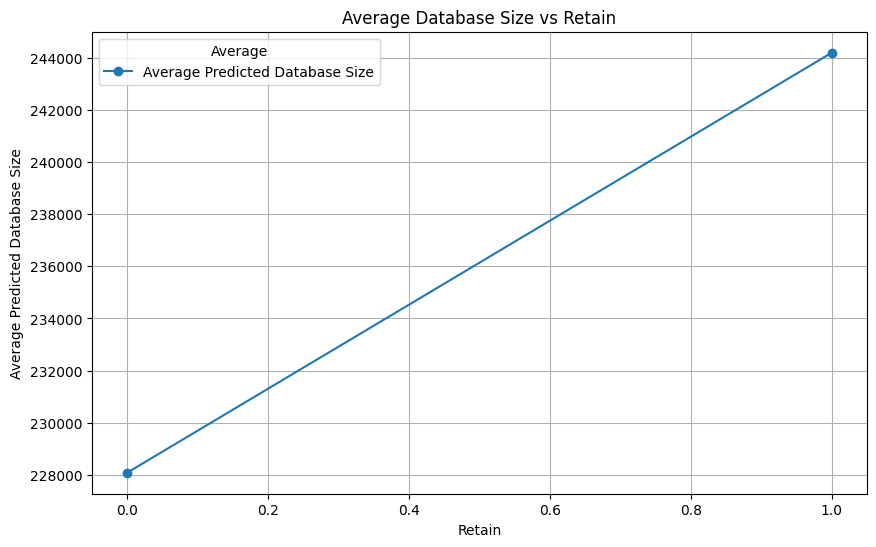

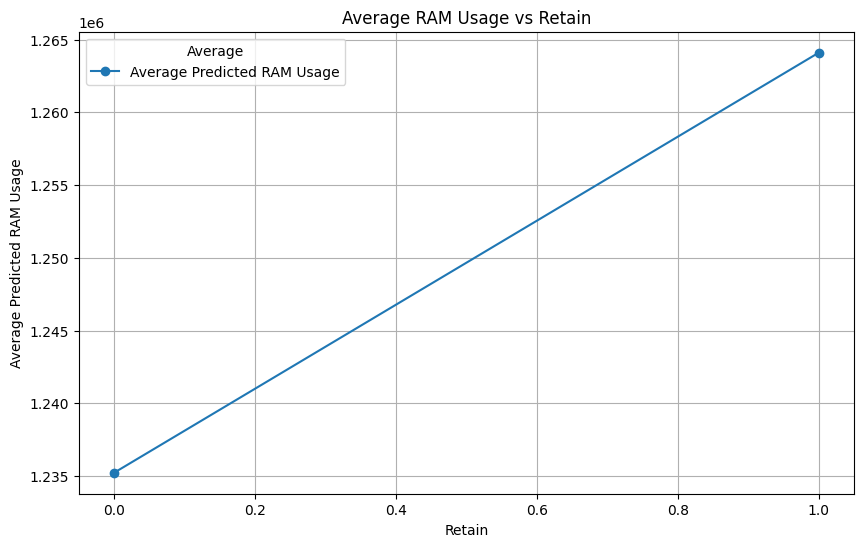

In [15]:
# Group by retain and calculate the mean predicted_database_size
mean_df_retain = df.groupby('retain')['database_size'].mean().reset_index()

# Plot the averaged database size vs retain
plt.figure(figsize=(10, 6))
plt.plot(mean_df_retain['retain'], mean_df_retain['database_size'], 'o-', label="Average Predicted Database Size")
plt.title("Average Database Size vs Retain")
plt.xlabel('Retain')
plt.ylabel('Average Predicted Database Size')
plt.grid(True)
plt.legend(title='Average')
plt.show()

# Group by retain and calculate the mean predicted_ram_usage
mean_df_ram_retain = df.groupby('retain')['ram_usage'].mean().reset_index()

# Plot the averaged RAM usage vs retain
plt.figure(figsize=(10, 6))
plt.plot(mean_df_ram_retain['retain'], mean_df_ram_retain['ram_usage'], 'o-', label="Average Predicted RAM Usage")
plt.title("Average RAM Usage vs Retain")
plt.xlabel('Retain')
plt.ylabel('Average Predicted RAM Usage')
plt.grid(True)
plt.legend(title='Average')
plt.show()


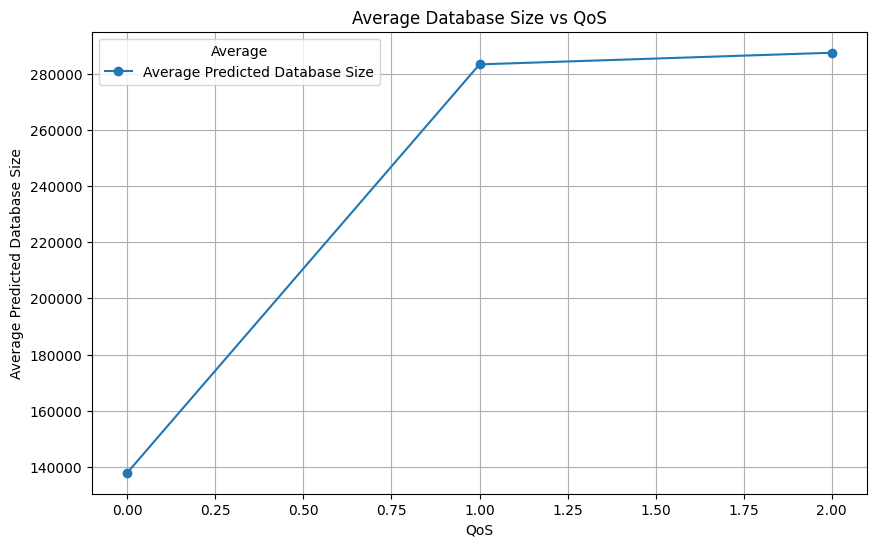

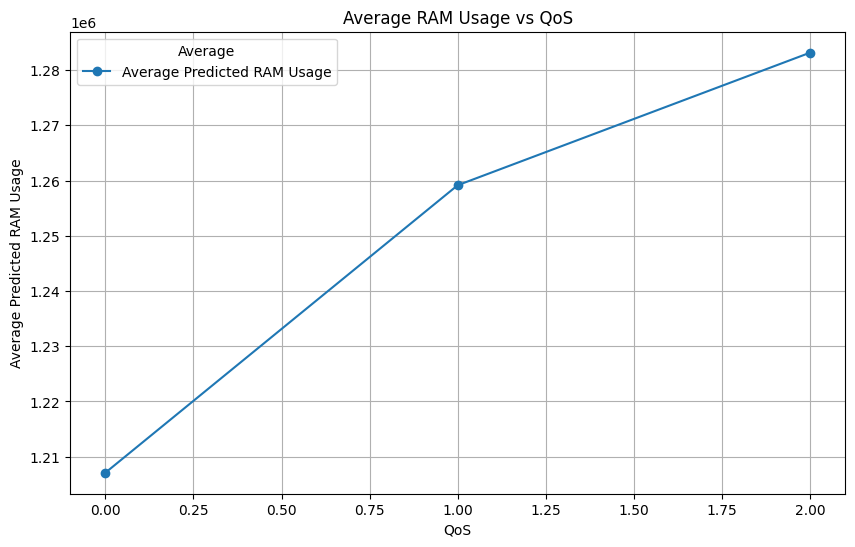

In [16]:
# Group by qos and calculate the mean predicted_database_size
mean_df_qos = df.groupby('qos')['database_size'].mean().reset_index()

# Plot the averaged database size vs qos
plt.figure(figsize=(10, 6))
plt.plot(mean_df_qos['qos'], mean_df_qos['database_size'], 'o-', label="Average Predicted Database Size")
plt.title("Average Database Size vs QoS")
plt.xlabel('QoS')
plt.ylabel('Average Predicted Database Size')
plt.grid(True)
plt.legend(title='Average')
plt.show()

# Group by qos and calculate the mean predicted_ram_usage
mean_df_ram_qos = df.groupby('qos')['ram_usage'].mean().reset_index()

# Plot the averaged RAM usage vs qos
plt.figure(figsize=(10, 6))
plt.plot(mean_df_ram_qos['qos'], mean_df_ram_qos['ram_usage'], 'o-', label="Average Predicted RAM Usage")
plt.title("Average RAM Usage vs QoS")
plt.xlabel('QoS')
plt.ylabel('Average Predicted RAM Usage')
plt.grid(True)
plt.legend(title='Average')
plt.show()


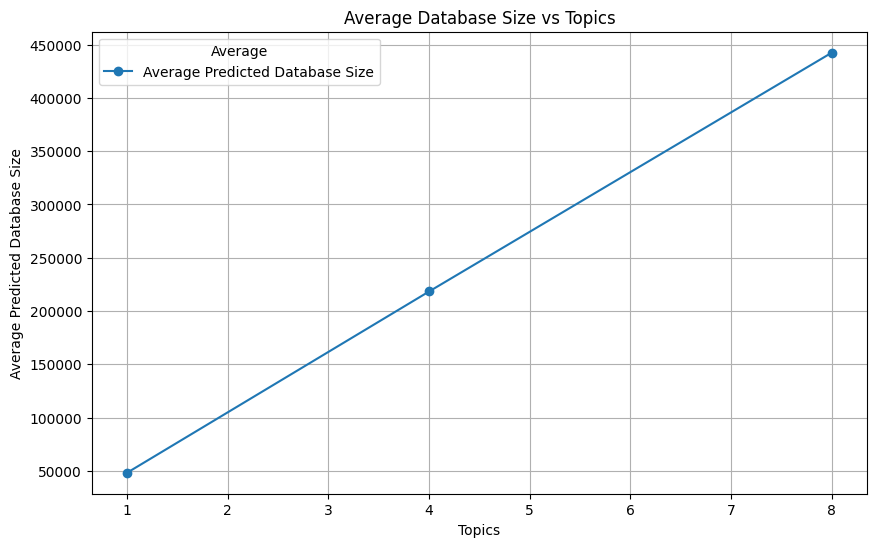

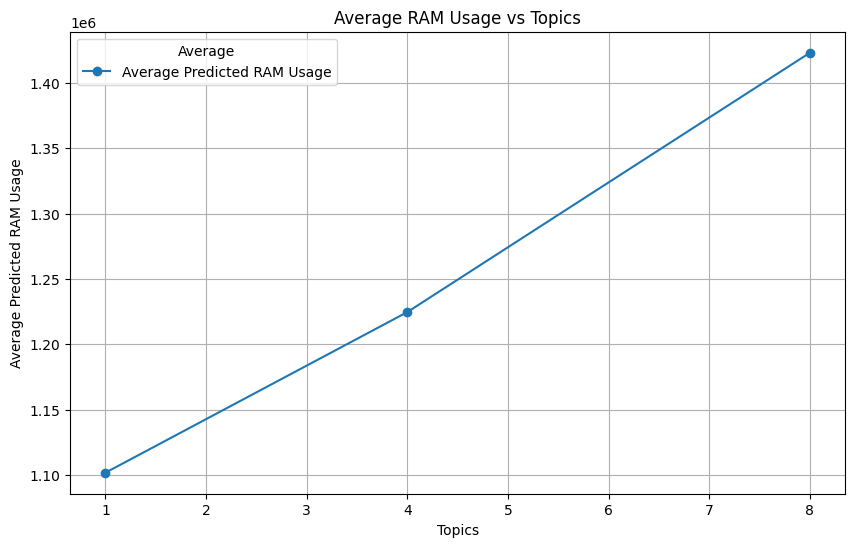

In [17]:
# Group by topics and calculate the mean predicted_database_size
mean_df_topics = df.groupby('topics')['database_size'].mean().reset_index()

# Plot the averaged database size vs topics
plt.figure(figsize=(10, 6))
plt.plot(mean_df_topics['topics'], mean_df_topics['database_size'], 'o-', label="Average Predicted Database Size")
plt.title("Average Database Size vs Topics")
plt.xlabel('Topics')
plt.ylabel('Average Predicted Database Size')
plt.grid(True)
plt.legend(title='Average')
plt.show()

# Group by topics and calculate the mean predicted_ram_usage
mean_df_ram_topics = df.groupby('topics')['ram_usage'].mean().reset_index()

# Plot the averaged RAM usage vs topics
plt.figure(figsize=(10, 6))
plt.plot(mean_df_ram_topics['topics'], mean_df_ram_topics['ram_usage'], 'o-', label="Average Predicted RAM Usage")
plt.title("Average RAM Usage vs Topics")
plt.xlabel('Topics')
plt.ylabel('Average Predicted RAM Usage')
plt.grid(True)
plt.legend(title='Average')
plt.show()
